# Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)



This notebook accompanies the blog "Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)" (TODO: add link)

## Introduction
When transcribing speech containing domain-specific terminologies in fields such as legal, financial, construction, higher education, or engineering, Amazon Transcribe’s [custom vocabularies](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html) feature can improve transcription quality, especially on key technical terms. 

To use custom vocabularies with Amazon Transcribe, you need a list of domain-specific terms. Using a collection of videos or audio files (i.e., your dataset) that you want transcribed with high accuracy, you can send a portion of your dataset to Amazon Transcribe to identify terms it has difficulty with, indicated by low-confidence scores. You can use Amazon A2I to send these low-confidence predictions directly to a human to manually review and transcribe the terms. This walkthrough will demonstrate how you can process the results obtained from Amazon A2I to quickly to build a custom vocabulary, at scale.

In summary, in this walkthrough you will:
* Send a subset of videos to Amazon Transcribe to find terms that are difficult to transcribe.
* Set up a human review workflow using Amazon A2I to send low-confidence predictions to your human workforce for manual review and transcription.
* Create a custom vocabulary using the results obtained from human workers.
* Test Amazon Transcribe on another subset of videos to assess the improvement in transcription quality. 


## Prerequisites

To run this notebook, you can simply execute each cell in order. Before beginning, you'll need:

* An AWS account.
* An S3 bucket you can write to -- please provide its name in BUCKET. The bucket must be in the same region as this SageMaker Notebook instance. You can also change the EXP_NAME to any valid S3 prefix. All the files involved in this demo will be stored in that prefix of your bucket.

To help understand this demo, the following are also recommended:
1. Basic understanding of AWS services [Amazon Transcribe](https://docs.aws.amazon.com/transcribe/latest/dg/what-is-transcribe.html) and Transcribe [custom vocabularies](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html), and the core components and workflow used by [Amazon A2I](https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-use-augmented-ai-a2i-human-review-loops.html). The notebook uses the [AWS SDK for Python (Boto3)](https://aws.amazon.com/sdk-for-python/) to interact with these services.  
2. Familiarity with Python and numpy.
3. Basic familiarity with [AWS S3](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html).

This notebook has been tested on a SageMaker notebook instance. The runtimes given are approximated on an ml.t2.medium instance. You can run it on a local instance by first executing the cell below on SageMaker and then copying the name of the role to your local copy of the notebook.

For more sample notebooks using A2I, visit this [Github repository](https://github.com/aws-samples/amazon-a2i-sample-jupyter-notebooks).

Let's get started!

# Setup

### Install Latest SDKs

In [5]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install --upgrade awscli
!pip install boto3 --upgrade
!pip install -U botocore

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.1.1)
     |████████████████████████████████| 3.2 MB 2.7 MB/s eta 0:00:01
  Attempting uninstall: awscli
    Found existing installation: awscli 1.18.66
    Uninstalling awscli-1.18.66:
      Successfully uninstalled awscli-1.18.66
Requirement already up-to-date: boto3 in /opt/conda/lib/python3.7/site-packages (1.14.8)
Requirement already up-to-date: botocore in /opt/conda/lib/python3.7/site-packages (1.17.8)


In [2]:
import io
import uuid
import botocore
import boto3
import time
import pprint
import json
import sagemaker
from sagemaker import get_execution_role
from datetime import datetime, timezone

### Region, Bucket, and Paths
Make sure all your resources are stored in the same region. You'll be using the same bucket for this entire walkthrough.

In [6]:
BUCKET = 'transcribe-a2i'
EXP_NAME = '' # Any valid S3 prefix.
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

In [7]:
sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name

# Amazon S3 (S3) client
s3 = boto3.client('s3', region)
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon Transcribe client
transcribe_client = boto3.client("transcribe")

### Roles and Permissions

Add the following policies to this role in IAM:
* AmazonAugmentedAIFullAccess
* AmazonTranscribeFullAccess

Or you can add a single policy, which will grant permissions to Amazon A2I and all integrated services (Amazon Rekognition and Amazon Transcribe)
* AmazonAugmentedAIIntegratedAPIAccess

Your execution role has the AmazonSageMakerFullAccess policy attached. This gives Amazon SageMaker permission to access your resources in S3 if the bucket or objects have the word `sagemaker` in the name. If your S3 bucket listed in `BUCKET` does not have sagemaker in the name, you will need to add an S3 policy to your execution role to give your role permissions to access your data objects in S3. The following is an example of an S3 policy:

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_input_bucket/*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:PutObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_output_bucket/*"
            ]
        }
    ]
}
```


Note: your default `MaxSessionDuration` for this execution role is 1 hour. It is recommended that you [increase Maximum CLI/API session duration](https://docs.aws.amazon.com/IAM/latest/UserGuide/roles-managingrole-editing-console.html#roles-modify_max-session-duration) to 2 hours. If you use less time, you may need to rerun some code cells containing functions.

In [8]:
from sagemaker import get_execution_role

ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::082907515444:role/service-role/AmazonSageMaker-ExecutionRole-20171204T115606'

### Upload Sample Video to S3
For this demo, we'll be analyzing videos from the official AWS playlist on introductory SageMaker videos, also available on [YouTube](https://www.youtube.com/watch?v=uQc8Itd4UTs&list=PLhr1KZpdzukcOr_6j_zmSrvYnLUtgqsZz&index=1). Follow the steps below to copy the mp4 video files to your own S3 bucket.

In [9]:
!mkdir ./a2i_transcribe_test
!aws s3 sync s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/transcribe-notebook-demo/ ./a2i_transcribe_test

download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/transcribe-notebook-demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 to a2i_transcribe_test/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4


In [10]:
%%bash -s "$BUCKET"
aws s3 cp ./a2i_transcribe_test/ s3://$1/a2i_transcribe_demo/ --recursive

upload: a2i_transcribe_test/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 to s3://transcribe-a2i/a2i_transcribe_demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4


In [11]:
# You can give each transcription job any name. We attach a timestamp to each job name here
# to prevent conflicting job names in case we need to re-run any jobs.
now = datetime.now()
time_now = now.strftime("%H.%M.%S")

job_names = []
for i in range(1):
    job_names.append("AWS-sage-vid-" + str(i) + "-" + str(time_now))

# Path to folder
folder_path = f"s3://{BUCKET}/a2i_transcribe_demo/"

# Names of the video titles. If you want to test more videos, uncomment them below.
all_videos = [
             'Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4',
#              'Built-in Machine Learning Algorithms with Amazon SageMaker - a Deep Dive.mp4',
#              'Bring Your Own Custom ML Models with Amazon SageMaker.mp4',
#              'Train Your ML Models Accurately with Amazon SageMaker.mp4',
#              'Deploy Your ML Models to Production at Scale with Amazon SageMaker.mp4',
#              'Tune Your ML Models to the Highest Accuracy with Amazon SageMaker Automatic Model Tuning.mp4',
#              'Scale up Training of Your ML Models with Distributed Training on Amazon SageMaker.mp4',
#              'Use the Deep Learning Framework of Your Choice with Amazon SageMaker.mp4',
#              'Learn to Analyze the Co-Relation in Your Datasets Using Feature Engineering with Amazon SageMake.mp4',
#              'Get Scheduled Predictions on Your ML Models with Amazon SageMaker Batch Transform.mp4'
]

job_names

['AWS-sage-vid-0-22.58.25']

## Step 1: Initial Transcription
Our first step is to look at the performance of Amazon Transcribe “off-the-shelf” (i.e., without custom vocabulary or other modifications) and establish a baseline accuracy metrics. You can use the following `transcribe` function (mostly a wrapper around the API call) to start a transcription job. Note that the `vocab_name` parameter will be used later to specify custom vocabularies, and it’s currently defaulted to `None`.

For the purposes of this demo, we'll be transcribing the first video in the playlist. Feel free to experiment with additional videos we've provided, or your own content.

In [12]:
# Here is a transcribe function
def transcribe(job_name, job_uri, out_bucket, format="mp4", vocab_name=None):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
        vocab_name (str): name of custom vocabulary used;
                          optional, defaults to None
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        print("------" + format)
        if vocab_name is None:
            transcribe_client.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="en-US",
                OutputBucketName=out_bucket,
            )
        else:
            transcribe_client.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="en-US",
                OutputBucketName=out_bucket,
                Settings={'VocabularyName': vocab_name}
            )
        
        time.sleep(2)
        
        print(transcribe_client.get_transcription_job(TranscriptionJobName=job_name))

    except Exception as e:
        print(e)

In [15]:
# # Start a transcription job
transcribe(job_names[0], folder_path+all_videos[0], BUCKET)

------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-sage-vid-0-22.58.25', 'TranscriptionJobStatus': 'IN_PROGRESS', 'LanguageCode': 'en-US', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': 's3://transcribe-a2i/a2i_transcribe_demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4'}, 'Transcript': {}, 'StartTime': datetime.datetime(2020, 6, 22, 23, 11, 39, 778000, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2020, 6, 22, 23, 11, 39, 732000, tzinfo=tzlocal()), 'Settings': {'ChannelIdentification': False, 'ShowAlternatives': False}}, 'ResponseMetadata': {'RequestId': '792e47d6-2daf-4afa-8529-13cf5876e4e5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 22 Jun 2020 23:11:41 GMT', 'x-amzn-requestid': '792e47d6-2daf-4afa-8529-13cf5876e4e5', 'content-length': '467', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


### Check transcription job statuses

Wait until the status displays `COMPLETED` before moving on to the next cells. A transcription job for a 10-15 minute video typically takes roughly 5 minutes.

In [17]:
for job_name in job_names:
    print(transcribe_client.get_transcription_job(TranscriptionJobName=job_name)['TranscriptionJob']['TranscriptionJobStatus'])

COMPLETED


### Retrieve and Parse Transcription Results

When the transcription job finishes, the results will be stored in your specified S3 bucket as an output JSON file called “YOUR_JOB_NAME.json.” You can use the following function to retrieve your results, and parse them into sentences with time stamps, confidence scores, and other useful representations.

In [18]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from S3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (
        entire_transcript: str,
        sentences_and_times: [ {start_time (sec) : float,
                                end_time (sec)   : float,
                                sentence         : str,
                                min_confidence   : float (minimum confidence score of that sentence)
                                } ],
        confidences:  [ {start_time (sec) : float,
                         end_time (sec)   : float,
                         content          : str, (single word/phrase)
                         confidence       : float (confidence score of the word/phrase)
                         } ],
        scores: list of confidence scores
        )
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1
        
    sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": confidences[-1]["end_time"],
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
    return entire_transcript, sentences_and_times, confidences, scores

In [19]:
all_entire_transcript = []
all_sentences_and_times = []
all_confidences = []
all_scores = []
for i in range(1):
    print(i)
    print(f"Parsing {job_names[i]}.json")
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps(BUCKET,job_names[i]+".json")
    all_entire_transcript.append(entire_transcript_1)
    all_sentences_and_times.append(sentences_and_times_1)
    all_confidences.append(confidences_1)
    all_scores.append(scores_1)

0
Parsing AWS-sage-vid-0-22.58.25.json


In [23]:
# Sanity check!
print(all_sentences_and_times[0][69])

{'start_time': 307.04, 'end_time': '312.62', 'sentence': 'All the folders, all the files, all the content that you want actually process is sitting right there in that list.', 'min_confidence': 0.6972}


### Save the original transcripts to txt files
Let's save the full transcripts, as we'll be using this later for comparisons.

In [24]:
i = 1
for sentences_times in all_sentences_and_times:
    file0 = open(f"original_transcript_{i}.txt","w") 
    for tup in sentences_times:
        file0.write(tup['sentence'] + "\n") 
    file0.close()
    i = i + 1

### Histogram of confidence scores
Let’s take a look at the distribution of confidence scores. A majority of words in the video were transcribe with a confidence score greater than .90. 

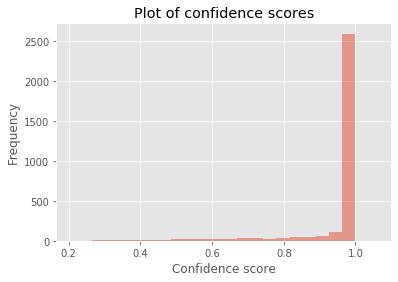

In [25]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

flat_scores_list = all_scores[0]

plt.xlim([min(flat_scores_list)-0.1, max(flat_scores_list)+0.1])
plt.hist(flat_scores_list, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

### Histogram of low confidence scores
Let’s filter out the high confidence scores to take a closer look at the lower ones.
You can experiment with different thresholds to see how many words fall below that threshold. For this demo, we recommend you use a threshold between 0.3 - 0.35 which corresponds to 4 - 8 human review tasks. All words under this threshold will be sent for human-review. 

In [26]:
THRESHOLD = 0.35

In [27]:
all_bad_scores = [i for i in flat_scores_list if i < THRESHOLD]
print(f"There are {len(all_bad_scores)} words that have confidence score less than {THRESHOLD}")

There are 8 words that have confidence score less than 0.35


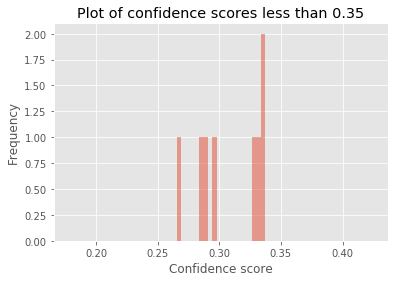

In [29]:
plt.xlim([min(all_bad_scores)-0.1, max(all_bad_scores)+0.1])
plt.hist(all_bad_scores, bins=20, alpha=0.5)
plt.title(f'Plot of confidence scores less than {THRESHOLD}')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

We can see that there is a nontrivial number of words classified with low confidence. As we’ll see later, technical terms are more often mis-transcribed, so it’s important that we correct those mistakes.

## Step 2: Human Review Workflow with A2I

Our next step is create a human review workflow that sends low confidence scores to human reviewers and then retrieves the corrected transcription they provide. This section contains the following steps:

1. Create a work task template that will be displayed to workers for every task. The template will be rendered with input data you provide, instructions to workers, and interactive tools to help workers complete your tasks.
2. Create a human review workflow, also called a flow definition. You use the flow definition to configure details about your human workforce and the human tasks they are assigned.
3. Create a human loop to start the human review workflow, sending data for human review as needed. In this example, you use a custom task type and start human loop tasks using the [Amazon A2I Runtime API](https://docs.aws.amazon.com/augmented-ai/2019-11-07/APIReference/Welcome.html). Each time StartHumanLoop is called, a task is sent to human reviewers.

### Workteam or Workforce


A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers.

When you use a private workforce, you also create work teams, a group of workers from your workforce that are assigned to Amazon Augmented AI human review tasks. You can have multiple work teams and can assign one or more work teams to each job.

To create your work team, visit the instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management.html). To preview the worker UI and tasks that are created by A2I to have humans review low-confidence trasncriptions, create a private work team and make yourself a worker on this team. 

After you have created your work team, replace YOUR_WORKTEAM_ARN below


In [30]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-east-2:082907515444:workteam/private-crowd/transcribe-a2i"

### Clients
Let's setup the rest of our clients.

In [32]:
import io
import json
import uuid
import time
import boto3
import botocore

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', region)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# S3 client
s3 = boto3.client('s3', region)

## Create Resources for an A2I Human Review
Now let's create the resources we'll need to build our human review workflow.

### Create Human Task UI

Amazon A2I uses Liquid, an open-source template language that can be used to “inject” data dynamically into HTML files.

In this walkthrough, we want for each task to enable a human reviewer to watch a section of the video and transcribe the speech they hear. The HTML template consists of three main parts:

1. A video player with a replay button that only allows the reviewer to play the specific subsection
2. A form for the reviewer to type and submit what they hear
3. Logic written in JavaScript to give the replay button its intended functionality

For over 60 other pre-built UIs, check out this [repository](https://github.com/aws-samples/amazon-a2i-sample-task-uis).

Here’s the template you’ll be using:


In [33]:
template = r"""
<head>
    <style>
        h1 {
            color: black;
            font-family: verdana;
            font-size: 150%;
        }
    </style>
</head>
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video id="this_vid">
        <source src="{{ task.input.audioPath | grant_read_access }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <br />
    <br />
    <crowd-button onclick="onClick(); return false;"><h1> Click to play video section!</h1></crowd-button>
    <br />
    Video title: <strong>{{ task.input.video_title }}</strong>
    <br />

    <h3>Instructions</h3>
    <p>Transcribe the audio clip </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>.
    If the text matches the audio, please retype the same transcription.</p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases. </p>
    <p><strong>Important:</strong> If you encounter a technical term that has multiple words,
    please <strong>hyphenate</strong> those words together. For example, "k nearest neighbors" should be transcribed as "k-nearest-neighbors."</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2" label="Your transcription" placeholder="Please enter the transcribed text."></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button and listen carefully to the audio clip. Type what you hear in the box
            below. Replay the clip by clicking the button again, as many times as needed.</p>
    </full-instructions>

</crowd-form>

<script>
    var video = document.getElementById('this_vid');
    video.onloadedmetadata = function() {
        video.currentTime = {{ task.input.start_time }};
    };
    function onClick() {
        video.pause();
        video.currentTime = {{ task.input.start_time }};
        video.play();
        video.ontimeupdate = function () {
            if (video.currentTime >= {{ task.input.end_time }}) {
                video.pause()
            }
        }
    }
</script>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

The `{{ task.input.audioPath | grant_read_access }}` field grants access to and display a video using a path to the video’s location in an S3 bucket. To prevent the reviewer from navigating to irrelevant sections of the video, the `controls` parameter is omitted from the video tag and a single replay button is included to control which section can be replayed.

Below the video player, the `<crowd-text-area>` HTML tag creates a submission form that your reviewer will use to type and submit.

At the end of the HTML snippet, the `<script>` tag contains the logic for the replay button. The `{{ task.input.start_time }}` and `{{ task.input.end_time }}` fields allow you to inject the start and end times of the video subsection you want transcribed for the current task.

Now let's create a Human Task UI resource.

In [34]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-east-2:082907515444:human-task-ui/ui-transcribe-e6dbb430-37df-4e16-8f93-c6a082ace713


### Flow Definition

In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well.

For more details and instructions, see [here](https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html).


In [35]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'demo-flowdef-transcribe-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "DEMO: Determine Words/Phrases of Audio Clip: " + str(datetime.now())
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [36]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Active
Flow Definition is active


## Human Loops
### Sending sequences of words/phrases of low confidence for review
After setting up our Flow Definition, we're ready to use Amazon Transcribe and initiate human loops. While iterating through the list of transcribed words and their confidence scores, we create a HumanLoop task whenever the confidence score is below some threshold, `CONFIDENCE_SCORE_THRESHOLD`.

An important thing to consider is how we deal with a low-confidence word that is part of a phrase that was also mis-transcribed. To handle these cases, let’s write a function that gets the sequence of words centered about a given index, and the sequence's starting and ending timestamps:

In [37]:
# Use this function to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index):
    """
    gets the words transcribe found at most 3 away from the input index
    Returns:
        list: words at most 3 away from the input index
        int: starting time of the first word in the list
        int: ending time of the last word in the list
    """
    i = max(0, index - 3)
    j = min(len(words) - 1, index + 3)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

Then, for every word we encounter with low confidence, we send its associated sequence of neighboring words for human review:

In [38]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = THRESHOLD

count = 0
for index in range(1):
    this_uri = folder_path+all_videos[index]
    this_confidences = all_confidences[index]
    
    print("========= " + all_videos[index] + " =========")
    
    i = 0
    for obj in this_confidences:
        word = obj["content"]
        neighbors, start_time, end_time = get_word_neighbors(this_confidences, i)

        # Our condition for when we want to engage a human for review
        if (obj["confidence"] < CONFIDENCE_SCORE_THRESHOLD):

            # get the original sequence of words
            sequence = ""
            for block in neighbors:
                sequence += block['content'] + " "

            humanLoopName = str(uuid.uuid4())
            # "initialValue": word,
            inputContent = {
                "audioPath": this_uri,
                "start_time": start_time,
                "end_time": end_time,
                "original_words": sequence,
                "video_title": all_videos[index]
            }
            start_loop_response = a2i.start_human_loop(
                HumanLoopName=humanLoopName,
                FlowDefinitionArn=flowDefinitionArn,
                HumanLoopInput={
                    "InputContent": json.dumps(inputContent)
                }
            )
            human_loops_started.append(humanLoopName)
            #print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
            #print(f'Starting human loop with name: {humanLoopName}')
            #print(f'Sending words from times {start_time} to {end_time} to review')
            #print(f'The original transcription is "{sequence}" \n')
            
            count = count + 1
        else:
            pass
            #print(f'SentimentScore of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
            #print('No human loop created. \n')

        i=i+1

print(f'Number of tasks sent to review: {count}')

========= Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 =========
Number of tasks sent to review: 8


Let's also save the name of each human loop, in case we need to retrieve them later after shutting down this notebook instance.

In [39]:
file_hl = open("human_loops_names.txt","w") 
for name in human_loops_started:
    file_hl.write(name + "\n") 
file_hl.close()

### Check Status of Human Loop

In [41]:
!cat human_loops_names.txt
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')

70378c02-378e-4157-8fd4-c6874b7ac617
a591f962-4560-444f-9bd3-9ea7f4929467
c54c47e0-2a2b-436b-b7fd-4b1c70564160
afa94a1d-31c0-4fd5-8ece-efa1add02441
20227526-03a4-4ff2-aa45-c839dea5bcaf
8e8743c9-dc0e-4b74-a74a-f97b0fb6fe1c
c833d7cc-98c9-4ebf-90e4-5c785189f54a
d216e24b-930b-4744-a986-29885f61647e
HumanLoop Name: 70378c02-378e-4157-8fd4-c6874b7ac617
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://transcribe-a2i/a2i-results/demo-flowdef-transcribe-5beeeef9-e9ad-44e5-910f-8551a39666c7/2020/06/22/23/47/27/70378c02-378e-4157-8fd4-c6874b7ac617/output.json'}


HumanLoop Name: a591f962-4560-444f-9bd3-9ea7f4929467
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://transcribe-a2i/a2i-results/demo-flowdef-transcribe-5beeeef9-e9ad-44e5-910f-8551a39666c7/2020/06/22/23/47/27/a591f962-4560-444f-9bd3-9ea7f4929467/output.json'}


HumanLoop Name: c54c47e0-2a2b-436b-b7fd-4b1c70564160
HumanLoop Status: InProgress
HumanLoop Output Destination: {'

### Wait For Workers to Complete Task
We display the link to the private worker portal here for convenience.

In [42]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://0o2zgtto1c.labeling.us-east-2.sagemaker.aws


### Check Status of Human Loop Again
Wait for all human loop statuses to display `Completed` before continuing to the next section.

In [43]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)


HumanLoop Name: 70378c02-378e-4157-8fd4-c6874b7ac617
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://transcribe-a2i/a2i-results/demo-flowdef-transcribe-5beeeef9-e9ad-44e5-910f-8551a39666c7/2020/06/22/23/47/27/70378c02-378e-4157-8fd4-c6874b7ac617/output.json'}


HumanLoop Name: a591f962-4560-444f-9bd3-9ea7f4929467
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://transcribe-a2i/a2i-results/demo-flowdef-transcribe-5beeeef9-e9ad-44e5-910f-8551a39666c7/2020/06/22/23/47/27/a591f962-4560-444f-9bd3-9ea7f4929467/output.json'}


HumanLoop Name: c54c47e0-2a2b-436b-b7fd-4b1c70564160
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://transcribe-a2i/a2i-results/demo-flowdef-transcribe-5beeeef9-e9ad-44e5-910f-8551a39666c7/2020/06/22/23/47/27/c54c47e0-2a2b-436b-b7fd-4b1c70564160/output.json'}


HumanLoop Name: afa94a1d-31c0-4fd5-8ece-efa1add02441
HumanLoop Status: Completed
HumanLoop Output Destination: {'Outpu

### View Task Results

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 `OUTPUT_PATH` when all work is completed.

In [48]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

{   'flowDefinitionArn': 'arn:aws:sagemaker:us-east-2:082907515444:flow-definition/demo-flowdef-transcribe-5beeeef9-e9ad-44e5-910f-8551a39666c7',
    'humanAnswers': [   {   'answerContent': {   'transcription': 'distributing '
                                                                  'data sets. '
                                                                  'What about '
                                                                  'pipe mode '},
                            'submissionTime': '2020-06-22T23:57:10.769Z',
                            'workerId': '0c80c0e372d55b16',
                            'workerMetadata': {   'identityData': {   'identityProviderType': 'Cognito',
                                                                      'issuer': 'https://cognito-idp.us-east-2.amazonaws.com/us-east-2_trT76h4Dh',
                                                                      'sub': '4fb6f14a-b8ac-4572-b275-3b763133c450'}}}],
    'humanLoopName': '70

## Step 3: Building custom vocabularies using A2I results

Using the corrected transcriptions from our human reviewers, let’s parse through these results to identify the domain-specific terms that we want to add to a custom vocabulary. 

### Retrieve A2I results
To get the technical terms identified by human review, we first accumulate all human-reviewed words into a list.

In [49]:
from string import punctuation

corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # add the human-reviewed answers split by spaces
    corrected_words += [word.strip(punctuation).lower() for word in json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")]

### Filtering out common English words
Now, we want to parse through these words and look for “uncommon” English words. An easy way to do this is to use a large English corpus and verify whether each of our human-reviewed words exists in this corpus:

In [50]:
# Create dictionary of English words
# Note that this corpus of words is not 100% exhaustive
import nltk
nltk.download('words')

from nltk.corpus import words
my_dict=set(words.words()) 

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [51]:
# Function for removing contractions
# Source: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
def remove_contractions(word_list):
    return [word for word in word_list if word not in contractions]

### View Technical/Uncommon Words
After removing contractions, human-reviewed words that are not in the English language corpus are likely to be the technical terms we are looking for.

In [52]:
word_set = set([])
for word in remove_contractions(corrected_words):
    if word:
        if word.lower() not in my_dict:
            if word.endswith('s') and word[:-1] in my_dict:
                print("")
            elif word.endswith("'s") and word[:-2] in my_dict:
                print("")
            else:
                word_set.add(word)

In [53]:
for word in word_set:
    print(word)

internet
ec2
sdk
distributing


### Create Custom Vocabulary
Using the technical terms identified above, it is now easier to manually create a custom vocabulary of those terms that we want Transcribe to be able to recognize. A custom vocabulary table enables options to tell Amazon Transcribe how each technical term is pronounced and how it should be displayed. More details on how to form a custom vocabulary table can be found [here](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html#create-vocabulary-table).

Note that as you process additional videos on the same topic, you can keep updating this list, and the number of new technical terms you'll have to add will likely decrease each time you get a new video.

We've built in advance a custom vocabulary (below) using parsed A2I results from the first and third videos with a 0.5 `THRESHOLD` confidence value. You can use this vocabulary for the rest of the notebook.

In [54]:
finalized_words=[['Phrase','IPA','SoundsLike','DisplayAs'], # This top line denote the column headers of the text file.
                 ['machine-learning','','','machine learning'],
                 ['amazon','','am-uh-zon','Amazon'],
                 ['boto-three','','boe-toe-three','Boto3'],
                 ['T.-three','','tee-three','T3'],
                 ['Sarab','','suh-rob','Sarab'],
                 ['E.C.R.','','ee-see-are','ECR'],
                 ['E.B.S.','','ee-bee-ess','EBS'],
                 ['jupyter','','joo-pih-ter','Jupyter'],
                 ['opt-M.L.','','opt-em-ell','/opt/ml'],
                 ['desktop','','desk-top','desktop'],
                 ['S.-Three','','ess-three','S3'],
                 ['S.D.K.','','ess-dee-kay','SDK'],
                 ['sagemaker','','sage-may-ker','SageMaker'],
                 ['mars-dot-r','','mars-dot-are','mars.R'],
                 ['I.A.M.','','eye-ay-em','IAM'],
                 ['V.P.C.','','','VPC'],
                 ['E.C.-Two','','ee-see-too','EC2'],
                 ['blazing-text','','','BlazingText'],
                ]

### Write the Custom Vocabulary Table to a Txt File

In [55]:
custom_vocab_file_name = "customvocab4.txt"
file1 = open(custom_vocab_file_name,"w")
template = '{}\t{}\t{}\t{}\n'
for line in finalized_words:
    file1.write(template.format(line[0],
                                line[1],
                                line[2],
                                line[3])
               )
file1.close()

### Upload Custom Vocabulary File to S3

In [56]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [57]:
upload_file(custom_vocab_file_name, BUCKET)

True

### Create the Custom Vocabulary for Amazon Transcribe
After saving your custom vocabulary table to a text file and uploading it to an S3 bucket, create your custom vocabulary with a specified name so that Amazon Transcribe can use it.

In [58]:
vocab_improved='sagemaker-custom-vocab'

In [59]:
transcribe = boto3.client("transcribe")
response = transcribe.create_vocabulary(
    VocabularyName=vocab_improved,
    LanguageCode='en-US',
    VocabularyFileUri='s3://' + BUCKET + '/' + custom_vocab_file_name
)

In [60]:
pp.pprint(response)

{   'LanguageCode': 'en-US',
    'ResponseMetadata': {   'HTTPHeaders': {   'connection': 'keep-alive',
                                               'content-length': '94',
                                               'content-type': 'application/x-amz-json-1.1',
                                               'date': 'Tue, 23 Jun 2020 '
                                                       '00:09:00 GMT',
                                               'x-amzn-requestid': '6df07299-d103-43d9-9d80-2eeabff7741f'},
                            'HTTPStatusCode': 200,
                            'RequestId': '6df07299-d103-43d9-9d80-2eeabff7741f',
                            'RetryAttempts': 0},
    'VocabularyName': 'sagemaker-custom-vocab',
    'VocabularyState': 'PENDING'}


Wait until the `VocabularyState` displays `READY` before continuing.

### Wait until its VocabularyState is READY

In [62]:
# Get the status of the vocab you created again
response2 = transcribe.get_vocabulary(
    VocabularyName=vocab_improved
)
pp.pprint(response2)

{   'DownloadUri': 'https://s3.us-east-2.amazonaws.com/aws-transcribe-dictionary-model-us-east-2-prod/082907515444/sagemaker-custom-vocab/819ec024-df59-4eab-a319-882ea19d16a4/input.txt?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEN%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMiJHMEUCIQDQDmQ1jTNJV%2B52%2BS21%2F1aP03jw49HeVuWJ96jPFpl35wIgII8DvpLlhxPOqaBA%2BIHepdwjU1CHlUXpy5awN%2B7G78EqtAMIaBABGgwyNDYzNjEzMjI3NTIiDKhaV7%2FGkUKVif9YpSqRA6RNrG0YaJrxOD9IHlCKA4eP6wwML%2B2WsGMcU8MhyUpCOKoGbpqDH0I4oWx1mVApgvry%2BQ0rJ3Dz5Yn7MOLFVozcsX7rq841dExRCw00zXByikbilaslcv5EWFLsCXxMaieytlU9%2FnhYsEu2k5KsBVS7WafY0FRuUNMk0OikAsmpPlpduN49P%2FPEBL7j8375s5jf4b3yCBzYzzzEikj6CF2A4VZhti1nxZUtKHCJasJ%2BLgNEMH7u60YF2XaqxUrm3EFoLqaq4Orq5Hmqkg1chQQGE2ii5LZglqnA7h81WRKit0G4Ul9XzcKN2WjN7RKL6%2BSS8Vwh86cu6hYZBPQGUMawx7jqXT%2BHjYRIepikI6VxBLuXw4OEd9x3SyFzSGDJVqALH%2FP%2Fu0%2Fox3RiTGVwbizXJHW5OBNvYB7fC%2FL9piG%2Fzq5%2F0XbA6%2BhkHKkqjoF0Wlr99R01NloMv%2B4BIna%2FTSXBspHyTRhIbERKrwlLgf1l0eArencJKs6umANyQ%2F%2BRqoxycilWmytqXvzp3k6n

## Step 4: Improved Transcription using custom vocabulary

### Re-transcribe using the Custom Vocabulary
Let's re-transcribe video using our custom vocabulary.

# New job names
# In-sample videos

In [66]:
job_name_custom_vid_0='AWS-custom-0-using-' + vocab_improved + str(time_now)
job_name_custom_vid_0

'AWS-custom-0-using-sagemaker-custom-vocab22.58.25'

Note that is you get the error `TypeError: 'TranscribeService' object is not callable`, your session may have timed out. You can resolve this re-running the code cell containing the Transcribe client declaration and the `transcribe` function.

In [67]:
# Start another transcription job using your custom vocabulary.
transcribe(job_name_custom_vid_0, folder_path+all_videos[0], BUCKET, vocab_name=vocab_improved)

TypeError: 'TranscribeService' object is not callable

Check the status of your transcription job. 

In [68]:
print(transcribe_client.get_transcription_job(TranscriptionJobName=job_name_custom_vid_0)['TranscriptionJob']['TranscriptionJobStatus'])

BadRequestException: An error occurred (BadRequestException) when calling the GetTranscriptionJob operation: The requested job couldn't be found. Check the job name and try your request again.

In [ ]:
all_entire_transcript_custom = []
all_sentences_and_times_custom = []
all_confidences_custom = []
all_scores_custom = []
for i in range(1):
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps(BUCKET,job_names_custom[i]+".json")
    all_entire_transcript_custom.append(entire_transcript_1)
    all_sentences_and_times_custom.append(sentences_and_times_1)
    all_confidences_custom.append(confidences_1)
    all_scores_custom.append(scores_1)

In [ ]:
# Sanity check!
print(all_sentences_and_times_custom[0][0])

### Write the Improved Transcripts to Txt File

In [ ]:
# Save the improved transcripts
i = 1
for list_ in all_sentences_and_times_custom:   
    file = open(f"improved_transcript_{i}.txt","w")
    for tup in list_:
        file.write(tup['sentence'] + "\n") 
    file.close()
    i = i + 1

### Results and Analysis

To analyze metrics on a larger sample size for this workflow, we've generated in advance a ground truth transcript, a transcription before custom vocabulary, and a transcription after custom vocabulary for each of the first four videos of the playlist. The first and third videos are the in-sample videos used to build the custom vocabulary you saw earlier. The second and fourth videos are used as out-sample videos to test Transcribe again after building the custom vocabulary.

Run the following cells to import the transcripts.

In [ ]:
!rm -rf a2i_transcribe_demo_results/

In [ ]:
%%bash -s "$BUCKET"
mkdir a2i_transcribe_demo_results
aws s3 sync s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files ./a2i_transcribe_demo_results


### Calculating Word Error Rate (WER)

The most common metric for speech recognition accuracy is called word error rate (WER), which can be roughly defined to be the proportion of transcription errors relative to the number of words that were actually said. More details can be found [here](https://en.wikipedia.org/wiki/Word_error_rate).

We'll be using a lightweight open-source Python library called JiWER for calculating WER between transcripts.

For more details, see the open-source [description](https://pypi.org/project/jiwer/).

In [ ]:
!pip install jiwer

In [ ]:
from jiwer import wer
import jiwer

In [ ]:
# Small example
ground_truth = "hello world"
hypothesis = "hello duck"

In [ ]:
wer(ground_truth, hypothesis)

In [ ]:
# Create a transformation function to preprocess transcript
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.SentencesToListOfWords(),
    jiwer.SentencesToListOfWords(word_delimiter=" "),
    jiwer.RemoveEmptyStrings()
])

### In-sample video metrics

In [ ]:
print("===== In-sample videos =====")
for index in [1,3]:
    print(f"Processing video #{index}")
    # Original transcript
    hypothesis_original = ""
    f1 = open(f"./a2i_transcribe_demo_results/original_transcript_{index}.txt", "r")
    for line in f1:
        hypothesis_original += (line.strip() + " ")
    f1.close()
    
    # Transcript after custom vocabulary
    hypothesis_2 = ""
    f2 = open(f"./a2i_transcribe_demo_results/improved_transcript_{index}.txt", "r")
    for line in f2:
        hypothesis_2 += (line.strip() + " ")
    f2.close()
    
    # Ground truth transcript
    ground_truth = ""
    f3 = open(f"./a2i_transcribe_demo_results/ground_truth_{index}.txt", "r")
    for line in f3:
        ground_truth += (line.strip() + " ")
    f3.close()
    
    # Calculate baseline accuracy
    baseline_accuracy = jiwer.wer(
        ground_truth, 
        hypothesis_original, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The baseline WER (before using custom vocabularies) is {baseline_accuracy}.")
    
    # Calculate new accuracy after custom vocabulary
    new_accuracy = jiwer.wer(
        ground_truth,
        hypothesis_2, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The WER (after using custom vocabularies) is {new_accuracy}.")

### Out-sample video metrics

In [ ]:
print("===== Out-sample videos =====")
for index in [2,4]:
    print(f"Processing video #{index}")
    # Original transcript
    hypothesis_original = ""
    f1 = open(f"./a2i_transcribe_demo_results/original_transcript_{index}.txt", "r")
    for line in f1:
        hypothesis_original += (line.strip() + " ")
    f1.close()
    
    # Transcript after custom vocabulary
    hypothesis_2 = ""
    f2 = open(f"./a2i_transcribe_demo_results/improved_transcript_{index}.txt", "r")
    for line in f2:
        hypothesis_2 += (line.strip() + " ")
    f2.close()
    
    ground_truth = ""
    f3 = open(f"./a2i_transcribe_demo_results/ground_truth_{index}.txt", "r")
    for line in f3:
        ground_truth += (line.strip() + " ")
    f3.close()
    
    # Calculate baseline accuracy
    baseline_accuracy = jiwer.wer(
        ground_truth, 
        hypothesis_original, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The baseline WER (before using custom vocabularies) is {baseline_accuracy}.")
    
    # Calculate new accuracy after custom vocabulary
    new_accuracy = jiwer.wer(
        ground_truth,
        hypothesis_2, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The new WER (after using custom vocabularies) is {new_accuracy}.")

## Discussion

We've provided a table summarizing the changes in WER scores below.

| In or Out of Sample | Video | Baseline WER (before custom vocabulary) | New WER (after custom vocabulary) | Percentage Change |
|------------|-------|-----------------------------------------|------------------------------------|-------------------|
| In-sample  | #1     | 5.18%                                   | 2.62%                              | -49%              |
| In-sample  | #3     | 11.94%                                  | 7.84%                              | -34%              |
| Out-sample | #2     | 7.55%                                   | 6.56%                              | -13%              |
| Out-sample | #4     | 10.91%                                  | 8.98%                              | -18%              |

There are several ways to interpret these results.

Let's first consider the percentage change column. By definition, we have $WER=\frac{S+D+I}{N}$, where $S$, $D$, and $I$ are the number of substitution, deletion, and insertion operations, respectively, needed to get from the outputted transcript to the ground truth, and $N$ is the total number of words. The percentage change is then the percentage change in the number of operations needed, so the decreases that we observed look pretty good.

If we consider absolute WER scores, the initial WER of 5.18%, for instance, might already feel sufficiently low — that's only around 1 in 20 words that are mis-transcribed! However, this rate can be misleading, since domain-specific terms are often the least common words spoken (relative to frequent words like “to,” “and,” “I” etc.) but the most commonly mis-transcribed. For applications like search engine optimization (SEO) and video organization by topic, it could be critical that these technical terms are transcribed correctly. Let’s take a look at how our custom vocabulary impacted the transcription rates of several important technical terms:

### Metrics for specific technical terms

#### In-sample videos:

Video #1:

| Technical Term | Ground Truth mentions | Original Transcript Mentions | New Transcript Mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 22                    | 4 (18%)                      | 22 (100%)               | +82%                    |
| EC2            | 15                    | 1 (7%)                       | 15 (100%)               | +93%                    |
| EBS            | 11                    | 7 (64%)                      | 11 (100%)                | +36%                    |
| Jupyter        | 5                     | 0 (0%)                       | 5 (100%)                | +100%                   |
| S3             | 3                     | 0 (0%)                       | 3 (100%)                | +100%                   |
| SDK            | 2                     | 0 (0%)                        | 2 (100%)                | +100%                 |
| BlazingText    | 2                     | 0 (0%)                        | 2 (100%)                | +100%                 |
| IAM            | 1                     | 0 (0%)                        | 1 (100%)                | +100%                 |
| **Total**      | **61**               | **12 (20%)**                  | **61 (100%)**           | **+80%**               |

Video #3:

| Technical Term | Ground Truth mentions | Original Transcript Mentions | New Transcript Mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 17                    | 4 (24%)                      | 17 (100%)               | +76%                    |
| ECR            | 7                     | 0 (0%)                       | 7 (100%)                | +100%                    |
| /opt/ml        | 6                     | 0 (0%)                       | 6 (100%)                | +100%                    |
| mars.R         | 3                     | 0 (0%)                       | 3 (100%)                | +100%                   |
| S3             | 1                     | 0 (0%)                       | 1 (100%)                | +100%                   |
| **Total**      | **34**               | **4 (12%)**                  | **34 (100%)**           | **+88%**               |


#### Out-sample videos:

Video #2:

| Technical Term | Ground Truth mentions | Original Transcript mentions | New Transcript mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 12                    | 3 (25%)                      | 12 (100%)               | +75%                    |
| BlazingText    | 3                     | 0 (0%)                       | 3 (100%)                | +100%                   |
| ECR            | 1                     | 0 (0%)                       | 1 (100%)                | +100%                   |
| **Total**      | **16**               | **3 (19%)**                  | **16 (100%)**           | **+81%**               |

Video #4:

| Technical Term | Ground Truth mentions | Original Transcript mentions | New Transcript mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 21                    | 4 (19%)                      | 20 (95%)                | +75%                    |
| EC2            | 11                    | 0 (0%)                       | 11 (100%)               | +100%                    |
| S3             | 7                     | 0 (0%)                       | 6 (86%)                 | +86%                    |
| ECR            | 2                     | 0 (0%)                       | 2 (100%)                | +100%                   |
| SDK            | 1                     | 0 (0%)                       | 1 (100%)                | +100%                   |
| EBS            | 1                     | 1 (100%)                     | 1 (100%)                | +0%                     |
| **Total**      | **43**               | **3 (12%)**                  | **41 (95%)**           | **+83%**               |


Now it does look like custom vocabularies were certainly worth the effort!

### Cleaning up
To avoid incurring unnecessary charges, delete resources when not in use.

## Recap

In this post, we walked through an example of how you can improve transcripts from Amazon Transcribe using custom vocabularies and an Amazon A2I human review workflow. This allows you to quickly identify domain-specific terms using your own private workforce and review workflows, and use these terms to build a custom vocabulary so that future mentions of term are transcribed with greater accuracy, at scale. Transcribing key technical terms correctly can be important for doing SEO, enabling highly specific textual queries, and grouping large quantities of video or audio files by important technical terms.

The full proof-of-concept Jupyter notebook can be found at this Github repository. Check out other blog posts covering integrations of Amazon A2I, such as [Using Amazon Textract with Amazon Augmented AI for processing critical documents](https://aws.amazon.com/blogs/machine-learning/using-amazon-textract-with-amazon-augmented-ai-for-processing-critical-documents/) and [Designing human review workflows with Amazon Translate and Amazon Augmented AI](https://aws.amazon.com/blogs/machine-learning/designing-human-review-workflows-with-amazon-translate-and-amazon-augmented-ai/).


## The End!
For a more detailed discussion with additional visuals, check out the accompanying blog post.